In [1]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


import tempfile
import time
import pickle as pkl;

import data.constants.constants as constants

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [21]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 4# was 64
batch_size_test = 4
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = './data/saved_models/' + '6_disease_aug_test_3' + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [22]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4}

In [23]:
pkl_load = open('dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [24]:
from collections import OrderedDict


def gen_state_dict(model_path):
    state_dict = torch.load(model_path)
    
    n_prefix = 0
    first_key = list(state_dict.keys())[0]
    words = first_key.split('.')
    for w in words:
        if w == 'module':
            n_prefix += 1
            
    if n_prefix == 0:
        new_state_dict = OrderedDict()
        for k,v in state_dict.items():
            new_state_dict['module.' + k] = state_dict[k]
        return new_state_dict        

    elif n_prefix > 1:
        new_state_dict = OrderedDict()
        for k,v in state_dict.items():
            new_k = k[7 * n_prefix:]
            new_state_dict[new_k] = state_dict[k]
        return new_state_dict 
    
    else:
        return state_dict

In [25]:
class ResNet(nn.Module):
    def __init__(self, model_file):
        super(ResNet, self).__init__()
        
        self.model_file = model_file
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=6, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(gen_state_dict(self.model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [26]:
gmodel = ResNet(model_path)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [27]:
gmodel.load_weights()
print('weights loaded successfully')

weights loaded successfully


In [28]:
gmodel.eval();

In [29]:
def check_contains(b1, b2):
    lx = b1['low_x'] <= b2['low_x']
    ly = b1['low_y'] <= b2['low_y']
    hx = b1['high_x'] >= b2['high_x']
    hy = b1['high_y'] >= b2['high_y']
    
    return lx and ly and hx and hy


In [30]:
def check_too_big(b):
    w = b['high_x'] - b['low_x']
    h = b['high_y'] - b['low_y']
    
    return w * h > 350000 # roughly if box is larger than 1/3 of the image then get rid of it

In [31]:
def compute_dist(b, avg):
    x = b['high_x'] - b['low_x']
    y = b['high_y'] - b['low_y']
    return abs(x * y - avg)

In [32]:
def compute_weight_score(b, heatmap, disease_avg):
    lx = b['low_x']
    ly = b['low_y']
    hx = b['high_x']
    hy = b['high_y']
    
    
    area = (hx - lx) * (hy - ly)
    distance = abs(area - disease_avg)
    
    # average value of the square divided by distance from average size for this disease type
    avg_pixel_val = np.sum(heatmap[ly:hy, lx:hx]) / (area)
    score = avg_pixel_val - distance / 1000
    
    return score

    

In [33]:
def get_bboxes(label_map, heatmap, disease):
    uniques = np.unique(label_map)
    boxes = {} # stored as x1, x2, y1, y2
    
    
    for u in uniques:
        low_x = 9999
        low_y = 9999
        high_x = -1
        high_y = -1
        
        for r in range(len(label_map)):
            for c in range(len(label_map[0])):
                
                cur = label_map[r][c]
                
                if cur == u:
                    low_x = min(low_x, c)
                    low_y = min(low_y, r)
                    high_x = max(high_x, c)
                    high_y = max(high_y, r)
                    
                    #explore_map = 1
                    
        boxes[u] = {'low_x' : low_x, 'low_y' : low_y,
                        'high_x' : high_x, 'high_y' : high_y}
     
    #print('all boxes:', boxes)
    
    # step 1: remove the boxes that are too big    
    boxes_temp = copy.deepcopy(boxes)
    for k, b in boxes.items():
        if check_too_big(b):
            boxes_temp.pop(k, None)
            
    boxes = boxes_temp
    
    # step 2: remove boxes that are contained in other boxes
#     boxes_temp = copy.deepcopy(boxes)

#     for k1, b1 in boxes.items():
#         for k2, b2 in boxes.items():
#             if k1 != k2 and check_contains(b1,b2):
#                 boxes_temp.pop(k2, None)
                    
#     boxes = boxes_temp
#     boxes_temp = {}
    
    # step 3: select the 3 boxes with the size closest to that of the average box size for this disease (based on training data)
    avg_size = constants.BBOX_AVG_SIZE[disease]
    
    box_dist_from_avg = {}
    best_boxes = {}
    for k, b in boxes.items():
        box_dist_from_avg[k] = compute_dist(b, avg_size)
        
    box_dist_from_avg = {k : v for k, v in sorted(box_dist_from_avg.items(), key=lambda x: x[1])}
    
    for i, k in enumerate(box_dist_from_avg.keys(), 1):
        best_boxes[k] = boxes[k]
        
        if i == 10: # take only the best 5
            break
                
    boxes = best_boxes
    #print(box_dist_from_avg)
    
    # step 4: use threshold values to give value to boxes based on how active it is
    box_weight_score = {}
    best_boxes = {}

    for k, b in boxes.items():
        box_weight_score[k] = compute_weight_score(b, heatmap, avg_size)
        #print('score:', box_weight_score[k], '| box: ', b)
        
        
    box_weight_score = {k : v for k, v in sorted(box_weight_score.items(), key=lambda x: -x[1])}

    for i, k in enumerate(box_weight_score.keys(), 1):
        best_boxes[k] = boxes[k]
        
        if i == 1: # take only the best 3
            break
            
    boxes = best_boxes
    
    #print(box_weight_score)
    #step 5: reset the keys on the boxes, for ex:  [5, 7, 11] --> [0, 1, 2]

    boxes_temp = {}
    idx = 0
    for k in boxes.keys():
        boxes_temp[idx] = boxes[k]
        idx += 1
        
    boxes = boxes_temp
        
    #print(boxes)
    #print('\n boxes delivered: \n', boxes)
    return boxes

In [34]:
def convert_to_rgb(np_arr):
    img = np.uint8(np.interp(np_arr, (np_arr.min() * 1/5, np_arr.max()), (0, 255)))
    img = cv2.applyColorMap(img, cv2.COLORMAP_HOT)
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    
    return img

In [45]:
def get_grad_map(data, model, disease):
    img_path = './data/sorted_images/' + data['disease'] + '/' + data['view'] + '/' + data['img_name']

    transforms = [
        #torchvision.transforms.RandomAffine(0, scale=(0.1, 0.1)),
        torchvision.transforms.ToTensor()]
    
    img = Image.open(img_path).convert('RGB')
    for t in transforms:
        img = t(img)
    
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    grad_activations = heatmap
    
    img = cv2.imread(img_path)
    
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = (heatmap - np.min(heatmap))/np.ptp(heatmap) # convert from [-1, 1] to [0, 1]
    heatmap = np.uint8(255 * heatmap)
        
    colormap = cv2.resize(np.float32(grad_activations), (1024, 1024), interpolation=cv2.INTER_CUBIC)
    colormap = convert_to_rgb(colormap)
    
    superimposed_img = colormap * 0.5 + img * 0.5
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 140 #* heatmap.mean()
        
    
    all_labels = measure.label(blobs)
        
    return all_labels, heatmap, grad_activations, img

In [46]:
def calc_iobb(data, model, disease):
    label_map, heatmap, _, _ = get_grad_map(data, model, disease)
        
    boxes = get_bboxes(label_map, heatmap, disease)
    
    
    single_level = np.array(label_map >= 1, dtype='int')
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    real_box = np.zeros((1024, 1024), dtype='int')
    x = int(data['x'])
    y = int(data['y'])
    width = int(data['width'])
    height = int(data['height'])
    for xi in range(x, x + width):
        for yi in range(y, y + height):
            real_box[yi][xi] = 1

    pred_boxes = np.zeros((1024, 1024), dtype='int')
    for _, b in boxes.items():
        for xi in range(b['low_x'], b['high_x']+1):
            for yi in range(b['low_y'], b['high_y']+1):
                pred_boxes[yi][xi] = 1
                
#     plt.figure()
#     plt.imshow(real_box)
#     plt.figure()
#     plt.imshow(pred_boxes)
    return jaccard_score(real_box.flatten(), pred_boxes.flatten())
    

In [47]:
def bbox_main(data, model, disease):
        
    all_labels, heatmap, grad_activations, img = get_grad_map(data, model, disease)
    
    grad_img = convert_to_rgb(grad_activations)

    # grad map image
    plt.figure() 
    plt.imshow(grad_img)
    #plt.savefig('visualizations/grad_map.png')

    heattest = cv2.resize(np.float32(grad_activations), (1024, 1024), interpolation=cv2.INTER_CUBIC)#, interpolation=cv2.INTER_LANCZOS4)
    heattest = convert_to_rgb(heattest)

    # upscaled grad map image
    plt.figure()
    plt.imshow(heattest)
    #plt.savefig('visualizations/grad_map_upscaled.png')
    #plt.savefig('grad_threshold')
    
    boxdict = get_bboxes(all_labels, heatmap, disease)
    print('boxes: ', boxdict)
    plt_image = cv2.imread('./map.jpg')
    
    # xray and grad map image
    fig, ax = plt.subplots()
    ax.imshow(plt_image)
    #plt.savefig('visualizations/xray_grad_map_overlay.png')


    # xray and grad map and bounding boxes image
    fig, ax = plt.subplots()
    ax.imshow(plt_image)

    for i in range(len(boxdict)):
        x = boxdict[i]['low_x']
        y = boxdict[i]['low_y']
        width = boxdict[i]['high_x'] - x
        height = boxdict[i]['high_y'] - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
        ax.add_patch(rect)
    rect = patches.Rectangle((data['x'], data['y']), data['width'], data['height'], linewidth=2, edgecolor='blue', facecolor='none' )
    ax.add_patch(rect)
    plt.show()
    #fig.savefig('visualizations/xray_grad_map_bbox_overlay.png')


    # just xray and bounding boxes
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     for i in range(len(boxdict)):
#         x = boxdict[i]['low_x']
#         y = boxdict[i]['low_y']
#         width = boxdict[i]['high_x'] - x
#         height = boxdict[i]['high_y'] - y
#         rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='red', facecolor='none' )
#         ax.add_patch(rect)
        
    #plt.savefig('visualizations/xray_bbox_overlay.png')

    # just xray image
#     plt.figure()
#     plt.imshow(img)
    #plt.savefig('visualizations/xray.png')

    
    print('IoBB = ', calc_iobb(data, model, disease))
    
    
'''
steps to use thresholded values for bbox calculations:
- upscale grad map
- pass into get_bbox
- remember to underscore for calc iobb
- create function that takes in bboxes and grad map
- return compute weighted value for each
- pick the best one
'''

'\nsteps to use thresholded values for bbox calculations:\n- upscale grad map\n- pass into get_bbox\n- remember to underscore for calc iobb\n- create function that takes in bboxes and grad map\n- return compute weighted value for each\n- pick the best one\n'

boxes:  {0: {'low_x': 337, 'low_y': 572, 'high_x': 715, 'high_y': 884}}


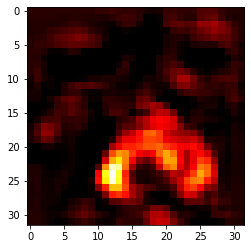

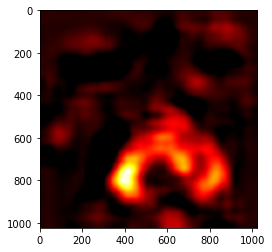

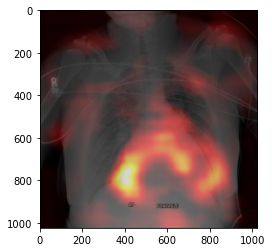

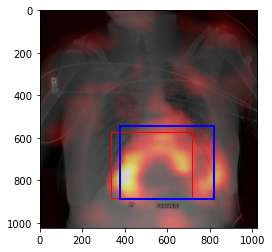

IoBB =  0.6419633619378005


In [75]:
bbox_main(data_bb['AP']['Cardiomegaly'][6], gmodel, 'Cardiomegaly')

In [71]:
iobb_vals = []
for i in range(10):
    if i not in [-1]:
        iobb_vals.append(calc_iobb(data_bb['AP']['Cardiomegaly'][i], gmodel, 'Cardiomegaly'))
        #print(i, ' : ', iobb_vals[i])

In [72]:
np.argmax(iobb_vals)

6

In [73]:
np.max(iobb_vals)

0.6419633619378005

In [52]:
iobb_vals.sort(reverse=True)

In [53]:
sum(iobb_vals) / len(iobb_vals)

0.023851022942953503

In [54]:
iobb_vals[0:10]

[0.19002721972079717,
 0.04848300970873787,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [298]:
iobb_vals[len(iobb_vals)//2]

0.0

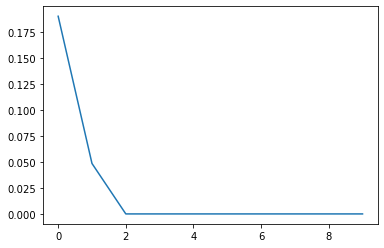

In [57]:
plt.plot(iobb_vals)

In [58]:
pkl_load = open('./dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("dataset for bounding box loaded in successfully")

dataset for bounding box loaded in successfully


In [59]:
bbox_results = {'AP' : {}, 'PA' : {}}

bbox_results['AP'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}
bbox_results['PA'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}

In [60]:
for view in data_bb.keys():
    for disease in bbox_results['AP'].keys():
        for i in range(len(data_bb[view][disease])):
            bbox_results[view][disease].append(calc_iobb(data_bb[view][disease][i], gmodel, disease))
        print(view, disease, 'complete')

/usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


AP Cardiomegaly complete


KeyboardInterrupt: 

In [64]:
bbox_results[view]['Cardiomegaly'].sort()

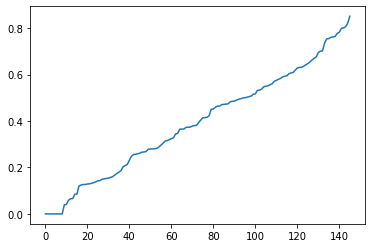

In [70]:
plt.plot(bbox_results['AP']['Cardiomegaly'])

In [48]:
data_bb.keys()

dict_keys(['AP', 'PA'])

In [61]:
for view in bbox_results.keys():
    for disease in bbox_results[view].keys():
        if bbox_results[view][disease]:
            mean = statistics.mean(bbox_results[view][disease])
            bbox_results[view][disease].sort()
            median = bbox_results[view][disease][len(bbox_results[view][disease]) // 2]
        print(view, disease, '| mean:', mean, '| median: ',median)
        print()

AP Cardiomegaly | mean: 0.391380675227793 | median:  0.3933954372821123

AP Effusion | mean: 0.043302258685944596 | median:  0.0

AP Mass | mean: 0.043302258685944596 | median:  0.0

AP Nodule | mean: 0.043302258685944596 | median:  0.0

AP Atelectasis | mean: 0.043302258685944596 | median:  0.0

PA Cardiomegaly | mean: 0.043302258685944596 | median:  0.0

PA Effusion | mean: 0.043302258685944596 | median:  0.0

PA Mass | mean: 0.043302258685944596 | median:  0.0

PA Nodule | mean: 0.043302258685944596 | median:  0.0

PA Atelectasis | mean: 0.043302258685944596 | median:  0.0



In [ ]:
'''
restructure:
compute iobb and gen bbox could go in the same function together
should all be 1 big thing

main
- generic stuff shared
- print out iobb
- display graph
'''